# Прогнозирование стоимости автомобиля по характеристикам
#### План 
   *  Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
   *  Обработаем и отнормируем признаки
   *  Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
   *  Сделаем вторую модель на основе нейронных сетей и сравним результаты
   *  Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
   *  Добавим в multi-input сеть обработку изображений
   *  Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [141]:
!pip -q install catboost pymorphy2 pymorphy2-dicts-ru nltk

# **Первая часть**
* Посторим наивную 






## Библиотеки

In [142]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

import sys
import warnings
import os
import time
import pymorphy2
import cv2
from tqdm.auto import tqdm

tqdm.pandas()  # for pandas progress_apply


# Keras
import tensorflow as tf

# GPU memory
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations


# Charts
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style
import matplotlib as mpl

mpl.style.use("ggplot")
%matplotlib inline

# Увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 12, 6

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
from pymystem3 import Mystem
from string import punctuation
import re

# For ML
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

warnings.filterwarnings("ignore")

print("Python       :", sys.version.split("\n")[0])
print("Numpy        :", np.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5


## Базовые переменные

In [143]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
# Постоянный сегодняшний день
date_today = pd.to_datetime("2021-07-14")

VAL_SIZE = 0.2

## Предобработка

In [144]:
def df_info():
    """
    Первичный просмотр данных (тренировочные, тестовые данные,
    уникальные значения и пропуски)
    """
    return pd.DataFrame(
        dict(
            train=train.dtypes,
            test=test.dtypes,
            nunique=data.nunique(),
            isnull=pd.isnull(data).sum(),
        )
    )


def mape(y_true, y_pred):
    """
    метрика оценки качества
    """
    return np.mean(np.abs((y_pred - y_true) / y_true))


def get_boxplot(column):
    """
    Функция для просмотра котегориальных признаков
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(
        x=column,
        y="price",
        data=data.loc[
            data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])
        ],
        ax=ax,
    )
    plt.xticks(rotation=45)
    ax.set_title("Boxplot for " + column)
    plt.show()


def visualize_distributions(titles_values_dict):
    """
    Функция для просмотра числовых признаков
    """
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


def preproc_data(df_input):
    """
    Функция включает в себя несколько функций для предварительной обработки данных
    """

    df_output = df_input.copy()

    # убираем не нужные для модели признаки (сделал  это выше)

    df_output.drop(
        ["description", "sell_id", "vehicleConfiguration", "mileagePerYearN"],
        axis=1,
        inplace=True,
    )
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    # Нормализация данных и логорифмирование
    scaler = MinMaxScaler()
    for column in numerical_features:
        # df_output[column] = np.log(df_output[column]) # это ухудшило результат
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype("category").cat.codes

    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)

    return df_output


def process_description(data):
    """
    Обработка признака description
    """
    # 1. Создадим список СТОП слов
    my_stopwords = stopwords.words("russian")
    # 2. Дополним список СТОП слов
    my_stopwords.extend(
        [
            "что",
            "это",
            "2017",
            "вот",
            "быть",
            "как",
            "в",
            "•",
            "и",
            "с",
            "на",
            "не",
            "по",
            "все",
            "для",
            "от",
            "в",
            "до",
            "при",
            "у",
            "2",
            "без",
            "за",
            "то",
            "есть",
            "1",
            "года",
            "только",
            "6",
            "км",
            "лет",
            "3",
            "а",
            "мы",
            "9",
            "вас",
            "5",
            "–",
            "м",
            "∙",
            "я",
            "ваш",
            "4",
            "вы",
            "7",
            "m",
            "к",
            "00",
            "год",
            "10",
            "8",
            "—",
            "л",
            "всех",
            "in",
            "о",
            "руб",
            "т",
            "же",
            "ни",
            "под",
            "можете",
            "была",
            "д",
            "тыс",
            "0",
            "s",
            "час",
            "вся",
            "всё",
            "наш",
            "г",
            "30",
            "11",
            "если",
            "возможна",
            "это",
            "предложение",
            "рублей",
            "себя",
            "☑️",
            "нам",
            "50",
            "ин",
            "c",
            "во",
            "✔",
            "х",
            "➥",
            "40",
            "ряд",
            "этого",
            "2018",
            "13",
            "●",
            "эл",
            "ти",
            "25",
            "могу",
            "01",
            "fi",
            "·",
            "2014",
            "✅",
            "ещё",
            "кредиту",
            "й",
            "дверь",
            "б",
            "позвоните",
            "72",
            "гк",
            "сел",
            "поехал",
            "ооо",
            "☛",
            "раз",
            "i",
            "60",
            "р",
            "кто",
            "тд",
            "2013",
            "мне",
            "там",
            "информации",
            "2016",
            "лицо",
            "еще",
            "2012",
            "оф",
        ]
    )
    # 3. Производим фильтрацию слов
    def filter_str(stopwords, st):
        split_str = st.split()
        filtered_str = " ".join((filter(lambda s: s not in my_stopwords, split_str)))
        return filtered_str

    data["description_filtered"] = data["description"].apply(
        lambda x: filter_str(stopwords, x)
    )
    data["description"] = data["description_filtered"]
    # 4. Удаляем все  неважные слова
    def preprocess_text(sen):
        sentence = sen
        sentence = re.sub(r"\s+[a-zA-Z]\s+", " ", sentence)
        sentence = re.sub(r"\s+", " ", sentence)
        return sentence

    data["description2"] = data["description"].apply(preprocess_text)
    # 5. Лемматизации текста
    morph = pymorphy2.MorphAnalyzer()

    def lem_str(str):
        split_str = str.split()
        filtered_str = " ".join(
            (map(lambda s: morph.parse(s)[0].normal_form, split_str))
        )
        return filtered_str

    data["description"] = data["description"].progress_apply(lem_str)

    return data

## Загрузка данных

In [145]:
# !kaggle competitions download -c sf-dst-car-price-prediction-part2 --force

# !echo "Unzipping files..."
# !unzip -q $PROJECT_PATH/sf-dst-car-price-prediction-part2.zip -d $PROJECT_PATH/
# !unzip -q sf-dl-car-classification.zip
# !unzip -q test.zip
# !unzip -q train.zip

!ls

catboost_info		  drive  nn_1.hdf5		    requirements.txt
catboost_submission2.csv  img	 nn1_submission-best55.csv  sample_data


In [146]:
PROJECT_PATH = "drive/MyDrive/Project-8/"
sample_submission = pd.read_csv(PROJECT_PATH + "sample_submission.csv")


def load_data():
    """
    Загружаем данные
    """
    train = pd.read_csv(PROJECT_PATH + "train.csv")
    test = pd.read_csv(PROJECT_PATH + "test.csv")
    print("Размерность тренировочного датасета: ", train.shape)
    print("Размерность тестового датасета: ", test.shape)
    return train, test


train, test = load_data()


def combine_data():
    """
    Обьединяем датафрейм
    """
    train["sample"] = 1  # помечаем где у нас трейн
    test["sample"] = 0  # помечаем где у нас тест
    # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
    test["price"] = 0
    df = pd.concat([train, test])
    return df


data = combine_data()

Размерность тренировочного датасета:  (6682, 22)
Размерность тестового датасета:  (1671, 21)


# Начнём с простой модели

## Model 1: Создадим "наивную" модель

*Эта модель будет предсказывать среднюю цену по модели и году выпуска. C ней будем сравнивать другие модели.*

In [147]:
# split
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED
)

In [148]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[["model_info", "productionDate"]]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)["price"].median())

# заполним ненайденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%"
)

Точность наивной модели по метрике MAPE: 19.88%


# EDA и модель на основе градиентного бустинга


In [149]:
# Cмотрим на данные
df_info()

,train,test,nunique,isnull
bodyType,object,object,17,0
brand,object,object,3,0
color,object,object,16,0
description,object,object,7654,0
engineDisplacement,object,object,48,0
enginePower,object,object,154,0
fuelType,object,object,4,0
mileage,int64,int64,3507,0
modelDate,int64,int64,43,0
model_info,object,object,122,0




1.   Признаки (за исключением целевого price) совпадают с train
2.   Есть пропуски в признаках:
    * Владельцы
    * Владение






## Предобработка признаков 

In [150]:
def preprocess_data(data):
    # bodyType
    data.bodyType = data.bodyType.str.split().apply(lambda s: s[0])
    data.bodyType.unique()
    # def map_body_type(df):
    #     df = df.copy()
    #     '''Обработка типа кузова'''
    #     df.loc[df.bodyType.str.contains('седан'), 'body_type'] = 'sedan'
    #     df.loc[df.bodyType.str.contains('внедорожник'), 'body_type'] = 'off-roader'
    #     df.loc[df.bodyType.str.contains('лифтбек'), 'body_type'] = 'liftback'
    #     df.loc[df.bodyType.str.contains(
    #         'универсал'), 'body_type'] = 'station wagon'
    #     df.loc[df.bodyType.str.contains('минивэн'), 'body_type'] = 'minivan'
    #     df.loc[df.bodyType.str.contains('купе'), 'body_type'] = 'compartment'
    #     df.loc[df.bodyType.str.contains('компактвэн'), 'body_type'] = 'compact MRV'
    #     df.loc[df.bodyType.str.contains('пикап'), 'body_type'] = 'pickup truck'
    #     df.loc[df.bodyType.str.contains('родстер'), 'body_type'] = 'roadster'
    #     df.loc[df.bodyType.str.contains('фургон'), 'body_type'] = 'the van'
    #     df.loc[df.bodyType.str.contains('кабриолет'), 'body_type'] = 'cabriolet'
    #     df.loc[df.bodyType.str.contains('микровэн'), 'body_type'] = 'microven'
    #     df.loc[df.bodyType.str.contains('лимузин'), 'body_type'] = 'limousine'
    #     df.loc[df.bodyType.str.contains('тарга'), 'body_type'] = 'targa'
    #     df.loc[df.bodyType.str.contains('фастбек'), 'body_type'] = 'fastback'
    #     df.loc[df.bodyType.str.contains('хэтчбек'), 'body_type'] = 'hechback'

    #     return df
    # df = map_body_type(df)

    # vehicleConfiguration
    data["vehicleConfiguration"] = data["vehicleConfiguration"].apply(
        lambda x: x.split()[1]
    )

    # enginePower
    # df.enginePower = df.enginePower.astype(str).str.replace('N12', '').astype(int)
    # df = df[(df['enginePower'] <= 639) & (df['enginePower'] >= 30)]
    data["enginePower"] = data["enginePower"].apply(lambda x: float(x.split()[0]))

    # modelDate
    data["modelDate"] = 2021 - data["modelDate"]
    data["modelDate"] = data["modelDate"].astype(float)

    # mileage
    data["mileage"] = data["mileage"].astype(float)

    # engineDisplacement
    def engineDisplacement(row):
        row = str(row)
        engine = re.findall("\d\.\d", row)
        if engine == []:
            return None
        return float(engine[0])

    # df_train.engineDisplacement = df_train.engineDisplacement.apply(
    #     lambda x: round(x / 1000, 1))

    # df_test.engineDisplacement = (df_test.engineDisplacement
    #                               .str.replace(' LTR', '0')
    #                               .str.strip()).astype(float)

    data["engineDisplacement"] = data["engineDisplacement"].apply(engineDisplacement)
    data["engineDisplacement"].fillna(data["engineDisplacement"].median(), inplace=True)
    data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

    data.loc[data.engineDisplacement == "undefined", "engineDisplacement"] = "2.0"
    data.loc[data.engineDisplacement == "0.7", "engineDisplacement"] = "1.0"

    # numberOfDoors
    data["numberOfDoors"] = data["numberOfDoors"].apply(lambda s: str(int(s)))

    # name
    data["name"] = data["name"].str.split().apply(lambda s: s[0])

    # Владение
    def num_of_months(row):
        if pd.notnull(row):
            list_ownership = row.split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ["год", "года", "лет"]:
                    return int(list_ownership[0]) * 12
                return int(list_ownership[0])
            return int(list_ownership[0]) * 12 + int(list_ownership[3])

    data["Владение"] = data["Владение"].apply(num_of_months).astype(float)
    data["Владение"] = data["Владение"].fillna(data["Владение"].median()).astype(float)

    # Владельцы
    # df.Владельцы = df.Владельцы.fillna('1\xa0владелец')
    # change_dict = {
    #     '3 или более': 3,
    #     '1\xa0владелец': 1,
    #     '2\xa0владельца': 2
    # }
    # df.Владельцы = df.Владельцы.replace(to_replace=change_dict)

    data["Владельцы"] = data[["Владельцы"]].fillna(
        data["Владельцы"].value_counts().index[0]
    )
    data["Владельцы"] = data["Владельцы"].apply(lambda x: str(x.split()[0]))
    data["Владельцы"] = data["Владельцы"].astype(str)

    # mileagePerYearN
    data["mileagePerYearN"] = data["mileage"] / data["productionDate"]
    data["mileagePerYearN"] = data["mileagePerYearN"].round()

    def cat_mileagePerYear(x):
        # km per year category
        if x < 10000:
            x = 1
        elif 10000 <= x < 20000:
            x = 2
        elif 20000 <= x < 30000:
            x = 3
        elif 30000 <= x:
            x = 4
        return x

    data["mileagePerYear"] = data["mileagePerYearN"].apply(
        lambda x: cat_mileagePerYear(x)
    )
    data["mileagePerYear"] = data["mileagePerYear"].astype(str)
    data["mileagePerYear"]

    # "tax_cat"
    data["tax_cat"] = (
        pd.cut(
            data.enginePower,
            bins=[0, 100, 125, 150, 175, 200, 225, 250, 1000],
            right=True,
            labels=False,
        )
        + 1
    )

    # # age-type/age_type
    # data['car_age'] = (2020 - data['modelDate']).astype(int)
    # data['car_age'] = data.car_age.astype(int)
    # data.loc[data.car_age.between(0, 1), 'age_type'] = 'new_car'
    # data.loc[data.car_age.between(2, 5), 'age_type'] = 'used_car'
    # data.loc[data.car_age.between(6, 10), 'age_type'] = 'midage_car'
    # data.loc[data.car_age.between(11, 18), 'age_type'] = 'old_car'
    # data.loc[data.car_age.between(19, 30), 'age_type'] = 'rare_car'
    # data.loc[data.car_age > 30, 'age_type'] = 'very_rare_car'

    # data.miles = data.miles.astype(int)
    # med_miles = data.groupby('car_age')['miles'].median().to_dict()
    # data.loc[(df.miles < 20000) & (df.car_age > 11) & (
    #     data.bodytype != 'roadster'), 'age_type'] = 'rebuild_car'

    # def miles_add(row):
    #     row['miles'] = row['miles'] + med_miles[row['car_age']]
    #     return row

    # df.loc[(df.miles < 20000) & (df.car_age > 11) & (df.bodytype != 'roadster')] = df.loc[
    #     (df.miles < 20000) & (df.car_age > 11) & (df.bodytype != 'roadster')].apply(
    #     miles_add, axis=1)
    # дубликаты
    return data.drop_duplicates()

**Почему там много кода который закомментирован?**


* Была разная обработка признаков, смотрелась какая из версий лучше
* Большая часть удалена
* Была произведена глубокая чистка признаков, каждый признак рассматривался отдельно, были удаленны данные в тренировочной выборке которых нет в трейне, но это ухудшило результат
* Так же была произведена работа над созданием новых признаков,
но не все они дали хороший результат и часто коррелировали с другими признаками
* Оставляю часть кода, в надежде, что после дедлайна получится дальше поработать с данными и улучшить модель





In [151]:
data = preprocess_data(data)

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 1670
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   float64
 8   modelDate             8353 non-null   float64
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   object 
 12  price                 8353 non-null   float64
 13  productionDate        8353 non-null   int64  
 14  sell_id               8353 non-null   int64  
 15  vehicleConfiguration 

## Распределения числовых признаков

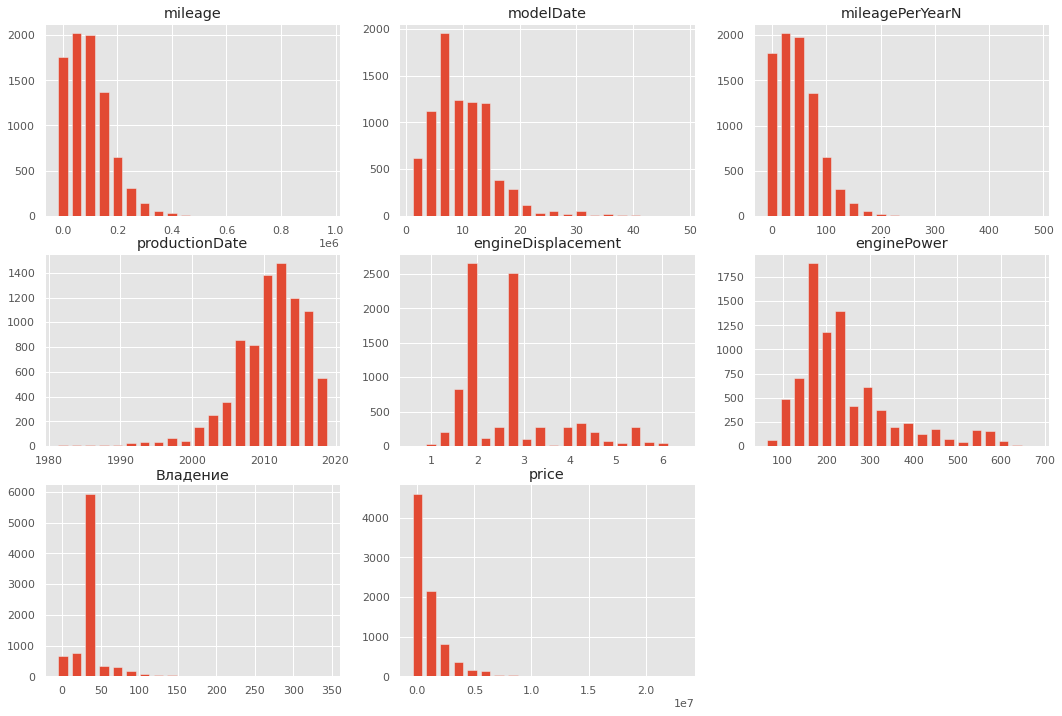

In [153]:
visualize_distributions(
    {
        "mileage": data["mileage"].dropna(),
        "modelDate": data["modelDate"].dropna(),
        "mileagePerYearN": data["mileagePerYearN"].dropna(),
        "productionDate": data["productionDate"].dropna(),
        "engineDisplacement": data["engineDisplacement"].dropna(),
        "enginePower": data["enginePower"].dropna(),
        "Владение": data["Владение"].dropna(),
        "enginePower": data["enginePower"].dropna(),
        "price": data["price"].dropna(),
    }
)

In [154]:
# data_categorical = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', 'name',
#                     'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'numberOfDoors', 'tax_cat', 'Владельцы', 'vehicleConfiguration'
#                     ]
# # Посмотрим финально на категориальные признаки:
# for column in data_categorical:
#     get_boxplot(column)

Остановимся на таком распределении как самом результативном (хотя некоторые признаки можно было отнести как к одной так и другой категории):

In [156]:
# Составим итоговый список категориальных признаков для модели:
categorical_features = [
    "bodyType",
    "brand",
    "color",
    "fuelType",
    "model_info",
    "name",
    "vehicleTransmission",
    "ПТС",
    "Привод",
    "Руль",
    "mileagePerYear",
    "numberOfDoors",
    "tax_cat",
    "Владельцы",
]

# Составим список числовых признаков:
numerical_features = [
    "mileage",
    "modelDate",
    "productionDate",
    "engineDisplacement",
    "enginePower",
    "mileagePerYear",
    "Владельцы",
    "Владение",
]

## Корреляционный анализ числовых переменных

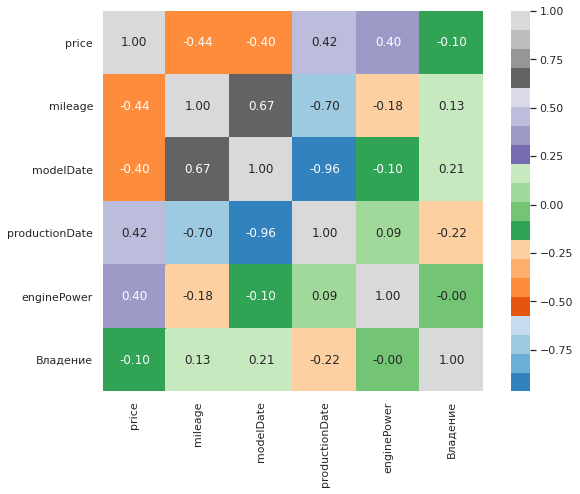

In [157]:
data_number = data[
    [
        "price",
        "mileage",
        "modelDate",
        "productionDate",
        "engineDisplacement",
        "enginePower",
        "Владение",
    ]
]
sns.set(font_scale=1)
plt.subplots(figsize=(10, 7))
_ = sns.heatmap(data_number.corr(), square=True, annot=True, fmt=".2f", cmap="tab20c")

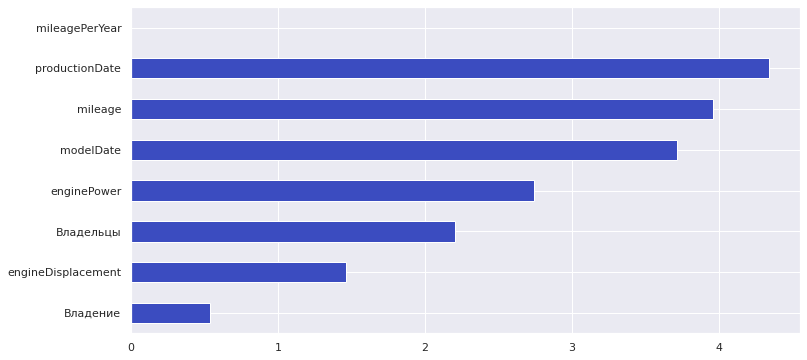

In [158]:
imp_num = pd.Series(
    f_classif(data[numerical_features], data["price"])[0], index=numerical_features
)
imp_num.sort_values(inplace=True)
_ = imp_num.plot(kind="barh", cmap="coolwarm")

### **Анализ числовых признаков:**

* Карта корреляции показывает, что сильной зависимости с "price" нет ни у одного признака
* Тем не менее 'mileage', 'modelDate', 'productionDate', 'engineDisplacement','enginePower','Владение', "mileagePerYearN" оказывают влияние на таргет(буду убирать поочередно)


In [159]:
# Запускаем ф-ю "preproc_data" которая нормирует данные, и выполняет Label Encoding или One-Hot Encoding.
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,price,productionDate,Владение,sample,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,name_0,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,name_9,name_10,name_11,name_12,name_13,name_14,name_15,name_16,name_17,name_18,name_19,name_20,name_21,name_22,name_23,name_24,name_25,name_26,name_27,name_28,name_29,name_30,name_31,name_32,name_33,name_34,name_35,name_36,name_37,name_38,name_39,name_40,name_41,name_42,name_43,name_44,name_45,name_46,name_47,name_48,name_49,name_50,name_51,name_52,name_53,name_54,name_55,name_56,name_57,name_58,name_59,name_60,name_61,name_62,name_63,name_64,name_65,name_66,name_67,name_68,name_69,name_70,name_71,name_72,name_73,name_74,name_75,name_76,name_77,name_78,name_79,name_80,name_81,name_82,name_83,name_84,name_85,name_86,name_87,name_88,name_89,name_90,name_91,name_92,name_93,name_94,name_95,name_96,name_97,name_98,name_99,name_100,name_101,name_102,name_103,name_104,name_105,name_106,name_107,name_108,name_109,name_110,name_111,name_112,name_113,name_114,name_115,name_116,name_117,name_118,name_119,name_120,name_121,name_122,name_123,name_124,name_125,name_126,name_127,name_128,name_129,name_130,name_131,name_132,name_133,name_134,name_135,name_136,name_137,name_138,name_139,name_140,name_141,name_142,name_143,name_144,name_145,name_146,name_147,name_148,name_149,name_150,name_151,name_152,name_153,name_154,name_155,name_156,name_157,name_158,name_159,name_160,name_161,name_162,name_163,name_164,name_165,name_166,name_167,name_168,name_169,name_170,name_171,name_172,name_173,name_174,name_175,name_176,name_177,name_178,name_179,name_180,name_181,name_182,name_183,name_184,name_185,name_186,name_187,name_188,name_189,name_190,name_191,name_192,name_193,name_194,name_195,name_196,name_197,name_198,name_199,name_200,name_201,name_202,name_203,name_204,name_205,name_206,name_207,name_208,name_209,name_210,name_211,name_212,name_213,name_214,name_215,name_216,na

In [160]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 1670
Columns: 429 entries, engineDisplacement to Владельцы_2
dtypes: float64(7), int64(1), uint8(421)
memory usage: 3.9 MB


In [161]:
# df_preproc.to_csv("df_preproc.csv", index=False)

## Split data

In [162]:
# Теперь выделим тестовую часть
train_data = df_preproc.query("sample == 1").drop(["sample"], axis=1)
test_data = df_preproc.query("sample == 0").drop(["sample"], axis=1)

y = train_data.price.values  # наш таргет
X = train_data.drop(["price"], axis=1)
X_sub = test_data.drop(["price"], axis=1)

#Model 2: CatBoostRegressor

In [163]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.085, shuffle=True, random_state=RANDOM_SEED  # 0.0848, #0.048
)

In [164]:
scores = {}
for i in tqdm(range(1, 21)):
    i /= 100
    model = CatBoostRegressor(
        iterations=15000,
        learning_rate=i,
        random_seed=RANDOM_SEED,
        eval_metric="MAPE",
        custom_metric=["RMSE", "MAE"],
        od_wait=1000,
    )
    _ = model.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose_eval=0,
        use_best_model=True,
    )
    scores[i] = round(mape(y_test, model.predict(X_test)) * 100, 2)

pd.DataFrame(scores.items(), columns=["learning_rate", "score"]).sort_values(
    "score"
).head(5)

,learning_rate,score
10,0.11,11.96
6,0.07,12.13
1,0.02,12.15
5,0.06,12.20
2,0.03,12.22


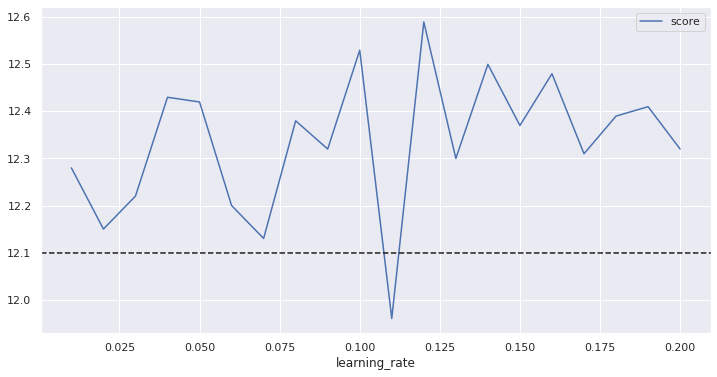

In [165]:
_ = (
    pd.DataFrame(scores.items(), columns=["learning_rate", "score"])
    .plot(x="learning_rate", y="score")
    .axhline(12.1, color="k", linestyle="--")
)

Запустила цикл для нахождения оптимального значения learning rate 

In [166]:
model = CatBoostRegressor(
    iterations=15000,
    learning_rate=0.11,
    random_seed=RANDOM_SEED,
    eval_metric="MAPE",
    custom_metric=["RMSE", "MAE"],
    od_wait=1000,
)
_ = model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose_eval=0,
    use_best_model=True,
)

In [167]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.96%


* базовый 12.10%
* лучший = 11.96%

Попыталась уличшить модель, но стало только хуже
https://towardsdatascience.com/powerful-feature-selection-with-recursive-feature-elimination-rfe-of-sklearn-23efb2cdb54e

In [168]:
# %%time
# from sklearn.feature_selection import RFE
# # here we want only one final feature, we do this to produce a ranking
# n_features_to_select = 10
# model = CatBoostRegressor(verbose=0)
# rfe = RFE(model, n_features_to_select)
# rfe.fit(X_train, y_train)

# from operator import itemgetter
# features = X_train.columns.to_list()
# for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
#     print(x, y)

## Submission

In [169]:
sub_predict_catboost = model.predict(X_sub)
sample_submission["price"] = sub_predict_catboost
sample_submission.to_csv("catboost_submission2.csv", index=False)

## **Выводы**

1. Проведен анализ и обработка признаков.
2. Сгенерированы новые признаки (feature engineering).
3. Проведена оценка значимости признаков.
4. Проведена нормализация и логарифмирование числовых признаков.
5. Протестирована и настроена ML модель CatBoostRegressor.
6. Точность CatBoostRegressor модели по метрике MAPE: 11.96%.



# Простая нейронная сеть. Simple Dense NN


In [170]:
!nvidia-smi

Wed Jul 21 13:40:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |    418MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [171]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,name_0,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,name_9,name_10,name_11,name_12,name_13,name_14,name_15,name_16,name_17,name_18,name_19,name_20,name_21,name_22,name_23,name_24,name_25,name_26,name_27,name_28,name_29,name_30,name_31,name_32,name_33,name_34,name_35,name_36,name_37,name_38,name_39,name_40,name_41,name_42,name_43,name_44,name_45,name_46,name_47,name_48,name_49,name_50,name_51,name_52,name_53,name_54,name_55,name_56,name_57,name_58,name_59,name_60,name_61,name_62,name_63,name_64,name_65,name_66,name_67,name_68,name_69,name_70,name_71,name_72,name_73,name_74,name_75,name_76,name_77,name_78,name_79,name_80,name_81,name_82,name_83,name_84,name_85,name_86,name_87,name_88,name_89,name_90,name_91,name_92,name_93,name_94,name_95,name_96,name_97,name_98,name_99,name_100,name_101,name_102,name_103,name_104,name_105,name_106,name_107,name_108,name_109,name_110,name_111,name_112,name_113,name_114,name_115,name_116,name_117,name_118,name_119,name_120,name_121,name_122,name_123,name_124,name_125,name_126,name_127,name_128,name_129,name_130,name_131,name_132,name_133,name_134,name_135,name_136,name_137,name_138,name_139,name_140,name_141,name_142,name_143,name_144,name_145,name_146,name_147,name_148,name_149,name_150,name_151,name_152,name_153,name_154,name_155,name_156,name_157,name_158,name_159,name_160,name_161,name_162,name_163,name_164,name_165,name_166,name_167,name_168,name_169,name_170,name_171,name_172,name_173,name_174,name_175,name_176,name_177,name_178,name_179,name_180,name_181,name_182,name_183,name_184,name_185,name_186,name_187,name_188,name_189,name_190,name_191,name_192,name_193,name_194,name_195,name_196,name_197,name_198,name_199,name_200,name_201,name_202,name_203,name_204,name_205,name_206,name_207,name_208,name_209,name_210,name_211,name_212,name_213,name_214,name_215,name_216,name_217,name_2

In [172]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [173]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               219136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 350,721
Trainable params: 350,721
Non-trainable params: 0
_________________________________________________________________


Компилируем модель:

In [174]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss="MAPE", optimizer=optimizer, metrics=["MAPE"])

Сохраняем чекпойнты и настраиваем EarlyStopping:

In [175]:
checkpoint = ModelCheckpoint(
    PROJECT_PATH + "best_model.hdf5", monitor=["val_MAPE"], verbose=0, mode="min"
)
earlystop = EarlyStopping(
    monitor="val_MAPE",
    patience=50,
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

Запускаем обучение на 500 эпох. batch_size устанавливаем достаточно большого размера, поскольку данные занимают немного места.

## Fit

In [176]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=0,
)

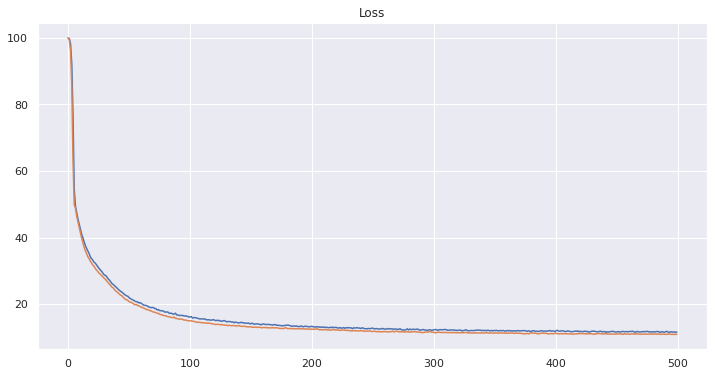

In [177]:
plt.title("Loss")
plt.plot(history.history["MAPE"], label="train")
plt.plot(history.history["val_MAPE"], label="test")
plt.show()

In [178]:
model.load_weights(PROJECT_PATH + "best_model.hdf5")
model.save("nn_1.hdf5")

In [179]:
test_predict_nn1 = model.predict(X_test)

print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.89%


на Каггл = 11.66%


In [180]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission["price"] = sub_predict_nn1[:, 0]
sample_submission.to_csv("nn1_submission-best55.csv", index=False)

## **Выводы**
1. Создана нейронная сеть для работы с табличными признаками.
2. Настроены параметры сети (протестированы различные комбинации слоев, количества нейронов в слоях, варианты batch и dropout нормализации).
3. Лучшая метрика на тестах: 11.26%


# Multi-Input сеть: табличные данные + текст


## Model 4: NLP + Multiple Inputs

## Запускаем функцию 'process_description' с обработкой признака description

In [182]:
data = process_description(data)

In [183]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [184]:
# разбивка данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

## Tokenizer

In [185]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.05 s, sys: 13.6 ms, total: 1.06 s
Wall time: 1.07 s


In [ ]:
tokenize.word_index

In [187]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH
)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH
)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH
)

print(
    text_train_sequences.shape,
    text_test_sequences.shape,
    text_sub_sequences.shape,
)

(6114, 256) (568, 256) (1671, 256)
CPU times: user 975 ms, sys: 9.83 ms, total: 985 ms
Wall time: 984 ms


In [188]:
print(text_train.iloc[6])
print(text_train_sequences[6])

авто код5, вопрос телефону. всё работает, комплект колес, торг уместен. перекупщик салон беспокоить, помощь продажа авто нуждаюсь. из недостаток - трещина лобовой стекле. (коробка перебрать назад,поменять радиатор,помпу,крышка прокладками,пневму,свечи,катушки,колодка диск зад ,ризин зима лето новый масло bardahl.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

# RNN NLP

In [189]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(
    L.Embedding(
        len(tokenize.word_index) + 1,
        MAX_SEQUENCE_LENGTH,
    )
)
model_nlp.add(L.LSTM(300, return_sequences=True))
model_nlp.add(L.Dropout(0.6))  # 0.4
model_nlp.add(
    L.LSTM(
        128,
    )
)
model_nlp.add(L.Dropout(0.45))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

# MLP

In [190]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

# Multiple Inputs NN

In [191]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])

head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [192]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8134656     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 300)     668400      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 256, 300)     0           lstm[0][0]                       
______________________________________________________________________________________________

# Fit

In [193]:
optimizer = tf.keras.optimizers.Adamax(0.005)
model.compile(loss="MAPE", optimizer=optimizer, metrics=["MAPE"])

In [194]:
checkpoint = ModelCheckpoint(
    "best_model.hdf5", monitor=["val_MAPE"], verbose=0, mode="min"
)
earlystop = EarlyStopping(
    monitor="val_MAPE",
    patience=20,
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

In [195]:
history = model.fit(
    [text_train_sequences, X_train],
    y_train,
    batch_size=512,
    epochs=700,  # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list,
)

Epoch 1/700
12/12 [==============================] - 11s 387ms/step - loss: 99.9967 - MAPE: 99.9967 - val_loss: 99.9862 - val_MAPE: 99.9862
Epoch 2/700
12/12 [==============================] - 4s 318ms/step - loss: 99.9505 - MAPE: 99.9505 - val_loss: 99.8791 - val_MAPE: 99.8791
Epoch 3/700
12/12 [==============================] - 4s 313ms/step - loss: 99.7287 - MAPE: 99.7287 - val_loss: 99.4636 - val_MAPE: 99.4636
Epoch 4/700
12/12 [==============================] - 4s 315ms/step - loss: 99.0180 - MAPE: 99.0180 - val_loss: 98.3144 - val_MAPE: 98.3144
Epoch 5/700
12/12 [==============================] - 4s 314ms/step - loss: 97.2598 - MAPE: 97.2598 - val_loss: 95.6728 - val_MAPE: 95.6728
Epoch 6/700
12/12 [==============================] - 4s 313ms/step - loss: 93.5130 - MAPE: 93.5130 - val_loss: 90.3738 - val_MAPE: 90.3738
Epoch 7/700
12/12 [==============================] - 4s 318ms/step - loss: 86.3728 - MAPE: 86.3728 - val_loss: 80.8662 - val_MAPE: 80.8662
Epoch 8/700
12/12 [=======

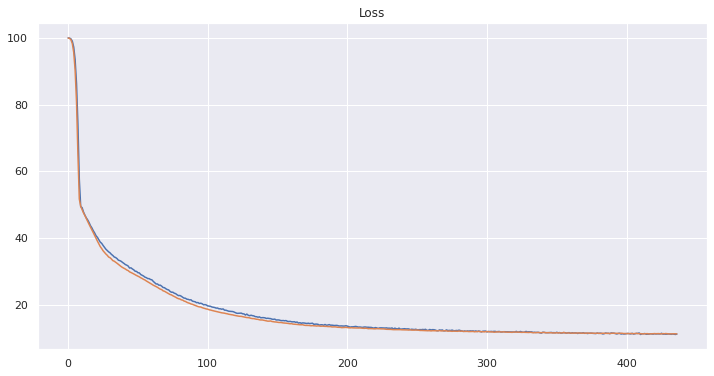

In [196]:
plt.title("Loss")
plt.plot(history.history["MAPE"], label="train")
plt.plot(history.history["val_MAPE"], label="test")
plt.show();

In [197]:
# model.load_weights(PROJECT_PATH +'best_model.hdf5')
model.save("nn_mlp_nlp.hdf5")

In [198]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.18%


### **Вывод**
1. Построена NLP модель для обработки тестовых описаний автомобиля.
2. Данные NLP модели и NN модели объеденены.
3. МАРЕ: 11.18% 



# Multi-Input сеть: табличные данные + текст + изображения

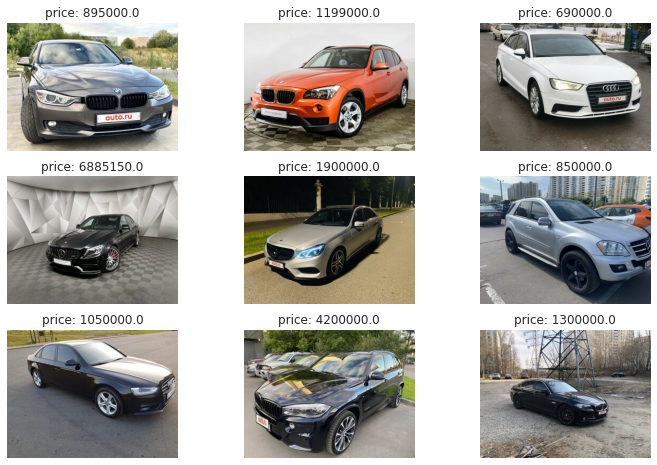

In [199]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image["sell_id"].values
random_image_cat = random_image["price"].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PROJECT_PATH + "/img/img/" + str(path) + ".jpg")
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title("price: " + str(random_image_cat[index]))
    plt.axis("off")
plt.show()

In [200]:
size = (320, 240)


def get_image_array(index):
    images_train = []
    for sell_id in tqdm(data["sell_id"].iloc[index].values):
        image = cv2.imread(PROJECT_PATH + "/img/img/" + str(sell_id) + ".jpg")
        assert image is not None
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print("images shape", images_train.shape, "dtype", images_train.dtype)
    return images_train

In [201]:
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)


images shape (6114, 240, 320, 3) dtype uint8



images shape (568, 240, 320, 3) dtype uint8



images shape (1671, 240, 320, 3) dtype uint8


## albumentations

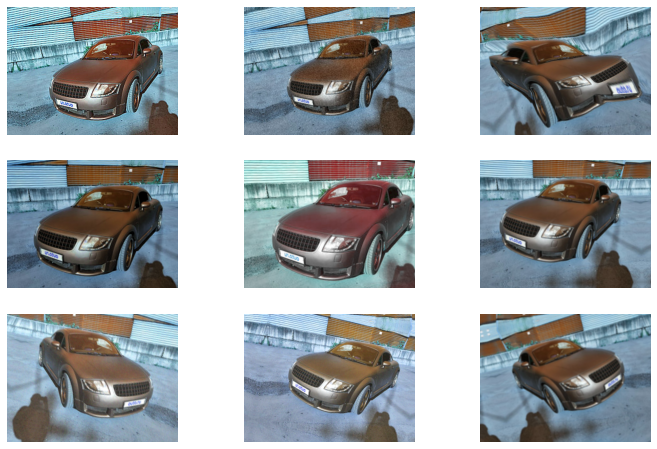

In [202]:
from albumentations import (
    HorizontalFlip,
    IAAPerspective,
    ShiftScaleRotate,
    CLAHE,
    RandomRotate90,
    Transpose,
    ShiftScaleRotate,
    Blur,
    OpticalDistortion,
    GridDistortion,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    GaussNoise,
    MotionBlur,
    MedianBlur,
    IAAPiecewiseAffine,
    IAASharpen,
    IAAEmboss,
    RandomBrightnessContrast,
    Flip,
    OneOf,
    Compose,
)


# пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose(
    [
        HorizontalFlip(),
        OneOf(
            [
                IAAAdditiveGaussianNoise(),
                GaussNoise(),
            ],
            p=0.3,
        ),
        OneOf(
            [
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.2),
                Blur(blur_limit=3, p=0.1),
            ],
            p=0.2,
        ),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
        OneOf(
            [
                OpticalDistortion(p=0.3),
                GridDistortion(p=0.2),
                IAAPiecewiseAffine(p=0.3),
            ],
            p=0.2,
        ),
        OneOf(
            [
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomBrightnessContrast(),
            ],
            p=0.3,
        ),
        HueSaturationValue(p=0.3),
    ],
    p=1,
)

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])["image"]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [203]:
def make_augmentations(images):
    print("применение аугментаций", end="")
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print(".", end="")
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict["image"]
        augmented_images[i] = augmented_image
    print("")
    return augmented_images

In [204]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [205]:
def process_image(image):
    return augmentation(image=image.numpy())["image"]


def tokenize_(descriptions):
    return sequence.pad_sequences(
        tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH
    )


def tokenize_text(text):
    return tokenize_([text.numpy().decode("utf-8")])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [
        image,
    ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [
        text,
    ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [
        text,
    ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices(
    (images_train, X_train, data.description.iloc[X_train.index], y_train)
).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (images_test, X_test, data.description.iloc[X_test.index], y_test)
).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices(
    (images_sub, X_sub, data.description.iloc[X_sub.index], y_sub)
).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__();


## Строим сверточную сеть для анализа изображений без "головы"


In [206]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights="imagenet", include_top=False, input_shape=(size[1], size[0], 3)
)
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [207]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential(
    [
        L.Input(shape=X.shape[1]),
        L.Dense(512, activation="relu"),
        L.Dropout(0.5),
        L.Dense(256, activation="relu"),
        L.Dropout(0.5),
    ]
)

In [208]:
# NLP
nlp_model = Sequential(
    [
        L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
        L.Embedding(
            len(tokenize.word_index) + 1,
            MAX_SEQUENCE_LENGTH,
        ),
        L.LSTM(256, return_sequences=True),
        L.Dropout(0.5),
        L.LSTM(128),
        L.Dropout(0.25),
        L.Dense(64),
    ]
)

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output]
)

# being our regression head
head = L.Dense(270, activation="relu")(combinedInput)
L.Dropout(0.7)
head = L.Dense(
    1,
)(head)

model = Model(
    inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input],
    outputs=head,
)
model.summary()

In [210]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss="MAPE", optimizer=optimizer, metrics=["MAPE"])

In [211]:
checkpoint = ModelCheckpoint(
    "best_model.hdf5", monitor=["val_MAPE"], verbose=0, mode="min"
)
earlystop = EarlyStopping(
    monitor="val_MAPE",
    patience=10,
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

In [212]:
history = model.fit(
    train_dataset.batch(30),
    epochs=100,
    validation_data=test_dataset.batch(30),
    callbacks=callbacks_list,
)

Epoch 1/100
204/204 [==============================] - 246s 981ms/step - loss: 52.3780 - MAPE: 52.3780 - val_loss: 75.2356 - val_MAPE: 75.2356
Epoch 2/100
204/204 [==============================] - 195s 953ms/step - loss: 30.6571 - MAPE: 30.6571 - val_loss: 47.9170 - val_MAPE: 47.9170
Epoch 3/100
204/204 [==============================] - 195s 951ms/step - loss: 24.5772 - MAPE: 24.5772 - val_loss: 22.1634 - val_MAPE: 22.1634
Epoch 4/100
204/204 [==============================] - 197s 961ms/step - loss: 21.0702 - MAPE: 21.0702 - val_loss: 18.8536 - val_MAPE: 18.8536
Epoch 5/100
204/204 [==============================] - 195s 954ms/step - loss: 18.7165 - MAPE: 18.7165 - val_loss: 16.8082 - val_MAPE: 16.8082
Epoch 6/100
204/204 [==============================] - 196s 958ms/step - loss: 17.1106 - MAPE: 17.1106 - val_loss: 15.1315 - val_MAPE: 15.1315
Epoch 7/100
204/204 [==============================] - 194s 950ms/step - loss: 15.9818 - MAPE: 15.9818 - val_loss: 15.1370 - val_MAPE: 15.1370

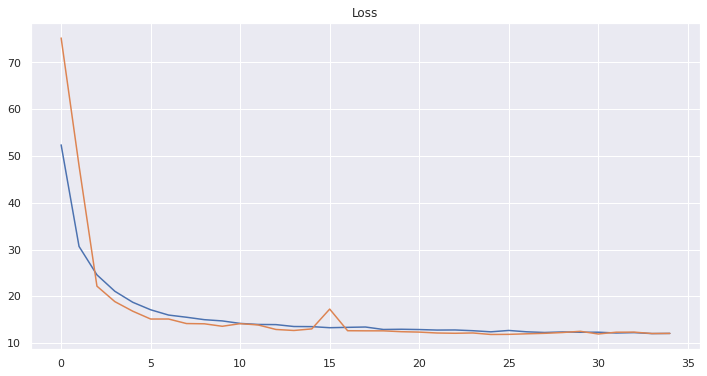

In [213]:
plt.title("Loss")
plt.plot(history.history["MAPE"], label="train")
plt.plot(history.history["val_MAPE"], label="test")
plt.show();

In [214]:
model.load_weights("best_model.hdf5")
model.save("nn_final.hdf5")

In [215]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.06%


In [216]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission["price"] = sub_predict_nn3[:, 0]
sample_submission.to_csv("nn3_submission1.csv", index=False)

# Blend

In [217]:
blend_predict = (test_predict_catboost + test_predict_nn1[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.58%


In [218]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:, 0]) / 2
sample_submission["price"] = blend_sub_predict
sample_submission.to_csv("blend_submission_1.csv", index=False)

на кагле 11.7,  33 место

In [219]:
blend_predict = (test_predict_catboost + test_predict_nn2[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.65%


In [221]:
blend_predict = (test_predict_nn2[:, 0] + test_predict_nn1[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.88%


**Делаем бленд лучших сетей с весами, больший вес для лучшей сети:**

In [223]:
blend_predict = (0.7 * (test_predict_nn1[:, 0]) + 0.3 * (test_predict_nn2[:, 0])) / 1
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.85%


## **Выводы:**
* Была произведена обработка и создание новых признаков
* Выполнена нормализация и стандартизация признаков
* Протестирована и настроена ML модель CatBoostRegressor, лучший результат = 11.96%
* Настроены параметры сети. Протестированы различные комбинации слоев, количества нейронов в слоях.
* NN модель показала на тестах: 10.89% на Каггл: 11.55%
* Была произведена чистка и пред обработка текста,
* NLP + Multiple Inputs показала на тестах: 11.18% на Каггл: 11.61%
* Заменила модель B3 на В4
* Модель "табличные данные + текст + изображения" показала на тестах: 12.26 на Каггл: 12.01
* На 21.07, 31 место на Каггл 😩


